## Task
    1. Turn it int script 
    2. Fix pdf download script

## importing libraries

In [1]:
# from googlesearch import search
import webbrowser
import re
import urllib.request
import requests
import bs4
from fake_useragent import UserAgent

In [2]:
import pandas as pd
import numpy as np
from fake_useragent import UserAgent
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

In [3]:
import re
import os

In [4]:
# from googlesearch import search

In [5]:
import time

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

## Customizing graph

In [31]:
##customizing matplotlib
plt.rcParams['figure.figsize'] = [10,8]# for 8:5 ratio
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-whitegrid')

## Reading the list

In [6]:
def get_comp_list(path = "Top 500 companies.txt"):
    with open(path, "r") as f:
        comp_list = f.readlines()
    return comp_list

## Searching PDF with no block(new)

In [7]:
def google_results(keyword, n_results=10):
    query = keyword
    query = urllib.parse.quote_plus(query) # Format into URL encoding
    number_result = n_results
    ua = UserAgent()
    google_url = f"https://www.google.com/search?q= {query} &num= + {number_result}"
    response = requests.get(google_url, {"User-Agent": ua.random})
    soup = BeautifulSoup(response.text, "html.parser")
    links = get_links(soup)
    titles = get_title_list(soup)
    desc_list = get_desc(soup)
    lst = []
    for (l,t,d) in zip(links,titles,desc_list):
        lst.append({"title" : t, "link" : l, "desc" : d})
    return lst[:number_result]

def get_links(soup):
    result = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    pattern = '\/url\?q\=(.*)\&sa'
    results = []
    for i in result:
        if "url" in str(i):
            text = str(i.find('a', href = True)['href'])
            results.append(re.search(pattern,text))
    #group(1) returns the text of the match object
    links=[i.group(1) for i in results if i != None]
    return links

def get_title_list(soup):
    result = soup.find_all('h3', attrs = {'class': 'zBAuLc'})
    titles = [i.text for i in result]
    return titles

def get_desc(soup):
    result = soup.findAll(True, {'class':"kCrYT"})
    desc_list = []
    for i,r in enumerate(result):
        if i % 2 != 0:
            desc_list.append(r.text)     
    return desc_list



In [8]:
def search_and_get_pdf(n = None,year = None, c=None):
    if c == None:
        c = int(input("Enter\n1. Normal Downlaod\n2. Redownload \n"))
    if c == 1:
        comp_list = get_comp_list()
        if year == None:
            year = int(input("Enter year : "))
        if n == None:
            n = int(input("\nHow many companies would you like to search? : "))
            comp_subset = comp_list[:n]
    elif c == 2:
        comp_subset = get_redownload_list(year)
    else:
        return None
    
    print(f"\nInitiating search of Annual reports for the {year}......\n")
    time.sleep(2)
    dic = {}
    for x in comp_subset:
        comp = x.strip()
        #if the pdf of a year exist
        if os.path.exists(f"pdf/{year}") == False:
            os.mkdir(f"pdf/{year}")
        if c == 1:
            if os.path.exists(f"pdf/{year}/{comp}"):
                if os.listdir(f"pdf/{year}/{comp}") != []:
                    print(f"{comp} already downloaded! Skipping search!")
                    continue
        
#       query = f"{comp} annual report site:\"https://www.bseindia.com\" filetype:pdf intext:\"{year} {year+1}\" " 
#         query = f"{comp} bse annual report {year}-{year+1} filetype:pdf intext:\"{comp}\" "
        query = f"{comp} bse annual report {year} filetype:pdf intext:\"{comp}\" "

#             query2 = f"{comp} annual report 2019-20 intext:\"Do you have a policy\" filetype:pdf"
        print(f"\nLinks for {comp} --------------------------------------------\n")
        links = []
        link = ""
        title = ""
        desc = ""
        result = google_results(query,1)
        for r in result:
            title = r["title"]
            desc = r["desc"]
            link = r["link"]
            print(f"\nTitle : {color.BOLD}{title}{color.END}")
            print(f"Description : {desc}")
            print(f"link :{link}")
#             if f"{year-1}" in desc or f"{year-1}" in title:
#                 print("SKIPPING.......")
#                 continue
            links.append(link)
#             break
        dic[x] = links
    return dic

In [9]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


## Downloading PDF from the list of links

In [10]:
def get_filesize(download_path):
    file_size = os.path.getsize(f"{download_path}")
    return file_size

In [11]:
def validate_links(file_name):
    pass

In [12]:
def get_filename(y):
    #check for pdf extension in link if not then add
    if re.findall("pdf", y) == []:
        file_name = os.path.split(y)[1] + ".pdf"
    else:
        file_name = os.path.split(y)[1]
    ##check for pdf in filename
    if re.findall("pdf",file_name) == []:
        y = y.replace(file_name,"")
        file_name = os.path.split(y[:-1])[1]
    
    i = file_name.find("pdf")
    if i > 0:
        file_name =  file_name[:i+3]
        
    ##check for special characters
    pattern= "'[@!#$^&*%<>?/\\|}{~:]'\"="
    
    for x in pattern:
        n = file_name.replace(x,"")
        file_name = n
    return n

In [13]:
##download directly
def download_pdf_direct(link,file_name,year,company_name):
    path = f"pdf/{year}/{company_name}/{file_name}"
    ua = UserAgent()
    try:
        response = requests.get(link, {"User-Agent": ua.random}, timeout = 180)
        save_file(response,file_name,path)
        return True
    except:
        return False

In [14]:
def save_file(response,filename,download_path):
#     download_path = "temp/test_file2.pdf"
    with open(f"{download_path}", 'wb') as pdf:
        pdf.write(response.content)
    file_size = os.path.getsize(f"{download_path}")
    size = round(file_size/(1024),3)
    print(f"\tdownloaded filesize : {size}KB")

In [15]:
##download at each folder
def download_all_pdf(dic,year = None):
    if year == None:
        year = int(input("Enter year : "))
    error_files = []
    stuck_files = []
    for x in dic:
        company_name = x.strip()
        link_of_pdfs = dic[x]
        path = "pdf"
        download_path = f"{path}/{year}/{company_name}"
        #go to pdf and create folder
        if os.path.exists(f"{path}/{year}") == False:
            os.mkdir(f"{path}/{year}")
        if os.path.exists(download_path) == False:
            os.mkdir(download_path)
        f_size = get_filesize(f"{download_path}")
        if os.listdir(download_path) == [] or f_size < 10000:
            print(f"\nDownloading report for {company_name}")
            check = ""
            for y in link_of_pdfs:
                #gets the pdf name from the link
                file_name = get_filename(y)
                try:
#                     print(f"{y}\n{file_name}\n{company_name}")
                    check = download_pdf_direct(y,file_name,year,company_name)
                except:
                    print(f"!!!!!------------Some error occured while downloading {file_name}, skipping to next link.")
                    error_files.append(company_name)
            if check:
                print(f"\t{company_name} report downloaded")
            else:
                print("!!!!------File is taking too long to download, skipping to next link")
                stuck_files.append(company_name)
    
    print("----------------------------------------------------------------------------------")
    print("All download complete!")
    
    
    if error_files != []:
        print("List of company not downloaded")
        with open(f"pdf/logs/failed_files_{year}.txt","w") as f:
            for x in error_files:
                print(f"\t{x}")
                f.write(f"{x}\n")
                
    if stuck_files!= []:
        print("List of company skipped as it took too long to download ")
        with open(f"pdf/logs/stuck_files_{year}.txt","w") as f:
            for x in stuck_files:
                print(f"\t{x}")
                f.write(f"{x}\n")

## Start search and download

In [16]:
def start_it():
    y = int(input("Enter year :"))
    choice = ""
    if os.path.exists(f"pdf/{y}"):
        print("\nChecking previous downloads for broken files......\n")
        time.sleep(2)
        check_files(y)
        choice = input("Do you want to re-download these files? y or n :")

    if choice == "y":
        comp_dict = search_and_get_pdf(None,y,2)
    else:
        comp_dict = search_and_get_pdf(None,y,1)

    download_all_pdf(comp_dict,y)
    print("\nReckecking for broken downloads.....\n")
    time.sleep(2)
    check_files(y)
    print(color.GREEN + "Everyting is completed successfully!" + color.END)
    
    describe(y)

## Validate downloaded files

## Check files

In [17]:
def check_files(year):
    f = open(f"pdf/logs/broken_files_{year}.txt","w")
    f2 = open(f"pdf/logs/success_files_{year}.txt","w")
    for i in os.listdir(f"pdf/{year}/"):
        path = f"pdf/{year}/{i}/"
        file = os.listdir(path)
        if file == []:
            continue
        file_path = path+file[0]
        file_size = os.path.getsize(file_path)
#         print(f"{i} File Size is :{file_size} bytes")
        #add to broken download list
        if file_size < 90000:
            f.write(f"{i}\n")
            print(f"{i} file size is too small {file_size} bytes\n")
        #add to success download list
        else:
            f2.write(f"{i}\n")

    f.close()
    f2.close()

## Get redownload list

In [18]:
def get_redownload_list(year):
    path = f"pdf/broken_files_{year}.txt"
    with open(path, "r") as f:
        r_list = f.readlines()
    return r_list

## get summary of download

In [19]:
def get_count(filepath):
    c = 0
    with open(filepath, "r") as file:
        Content = file.read()
        CoList = Content.split("\n")

        for i in CoList:
            if i:
                c += 1

    return c

In [20]:
def describe(year):
    succ_path = f"pdf/logs/success_files_{year}.txt"
    broken_path = f"pdf/logs/broken_files_{year}.txt"
    failed_path = f"pdf/logs/failed_files_{year}.txt"
    stuck_path = f"pdf/logs/stuck_files_{year}.txt"
    
    sum_success = 0
    sum_stuck = 0
    sum_broken = 0
    sum_fail = 0
    
    if os.path.exists(succ_path):
        sum_success = get_count(succ_path)
    if os.path.exists(failed_path):
        sum_fail = get_count(failed_path)
    if os.path.exists(broken_path):
        sum_broken = get_count(broken_path)
    if os.path.exists(stuck_path):
        sum_stuck = get_count(stuck_path)
    
    total = sum_broken + sum_fail + sum_stuck + sum_success
    print(f"""
    Downlaod summary:
    1. Success : {sum_success} ({round(sum_success/total*100,2)}%)
    2. Stuck : {sum_stuck} ({round(sum_stuck/total*100,2)}%)
    3. Broken : {sum_broken} ({round(sum_broken/total*100,2)}%)
    4. Failed : {sum_fail} ({round(sum_fail/total*100,2)}%)
    
    Total : {total}
    """)
    

In [29]:
def describe_all():
    year = [2017,2018,2019]
    sum_success = []
    sum_stuck = []
    sum_broken = []
    sum_fail = []
    
    for i in year:
        succ_path = f"pdf/logs/success_files_{i}.txt"
        broken_path = f"pdf/logs/broken_files_{i}.txt"
        failed_path = f"pdf/logs/failed_files_{i}.txt"
        stuck_path = f"pdf/logs/stuck_files_{i}.txt"

        if os.path.exists(succ_path):
            sum_success.append(get_count(succ_path)) 
        else:
            sum_success.append(0) 
            
        if os.path.exists(failed_path):
            sum_fail.append(get_count(failed_path))
        else:
            sum_fail.append(0) 
        if os.path.exists(broken_path):
            sum_broken.append(get_count(broken_path)) 
        else:
            sum_broken.append(0) 
        if os.path.exists(stuck_path):
            sum_stuck.append(get_count(stuck_path)) 
        else:
            sum_stuck.append(0) 
            
    d = {'Year':year,
         'Success' : sum_success,
         'Failed' : sum_fail,
         'Stuck' : sum_stuck,
        'Broken' : sum_broken
        }

    df = pd.DataFrame(d)
    plt.subplot(2,2,1)
    sns.barplot(data=df,x= 'Year', y = 'Success');
    plt.subplot(2,2,2)
    sns.barplot(data=df,x= 'Year', y = 'Failed');
    plt.subplot(2,2,3)
    sns.barplot(data=df,x= 'Year', y = 'Broken');
    plt.subplot(2,2,4)
    sns.barplot(data=df,x= 'Year', y = 'Stuck');

In [26]:
start_it()

Enter year : 2017



Checking previous downloads for broken files......

Bank of Baroda file size is too small 345 bytes

Bharti Airtel file size is too small 345 bytes

Coal India file size is too small 0 bytes

HDFC file size is too small 345 bytes

Larsen & Toubro file size is too small 0 bytes

Oil & Natural Gas Corporation file size is too small 43 bytes

Rajesh Exports file size is too small 345 bytes

Reliance Industries file size is too small 345 bytes

State Bank of India file size is too small 345 bytes

Tata Consultancy Services file size is too small 73106 bytes

Tata Steel file size is too small 345 bytes

Vedanta file size is too small 345 bytes



Do you want to re-download these files? y or n : n

How many companies would you like to search? :  100



Initiating search of Annual reports for the 2017......

Reliance Industries already downloaded! Skipping search!
Indian Oil Corporation already downloaded! Skipping search!
Oil & Natural Gas Corporation already downloaded! Skipping search!
State Bank of India already downloaded! Skipping search!
Bharat Petroleum Corporation already downloaded! Skipping search!
Tata Motors already downloaded! Skipping search!
Rajesh Exports already downloaded! Skipping search!
Tata Consultancy Services already downloaded! Skipping search!
ICICI Bank already downloaded! Skipping search!
Larsen & Toubro already downloaded! Skipping search!
HDFC Bank already downloaded! Skipping search!
Tata Steel already downloaded! Skipping search!
Hindalco Industries already downloaded! Skipping search!
NTPC already downloaded! Skipping search!
HDFC already downloaded! Skipping search!
Coal India already downloaded! Skipping search!
Mahindra & Mahindra already downloaded! Skipping search!
Infosys already downloaded! Sk

In [33]:
describe(2018)


    Downlaod summary:
    1. Success : 43 (43.0%)
    2. Stuck : 4 (4.0%)
    3. Broken : 53 (53.0%)
    4. Failed : 0 (0.0%)
    
    Total : 100
    


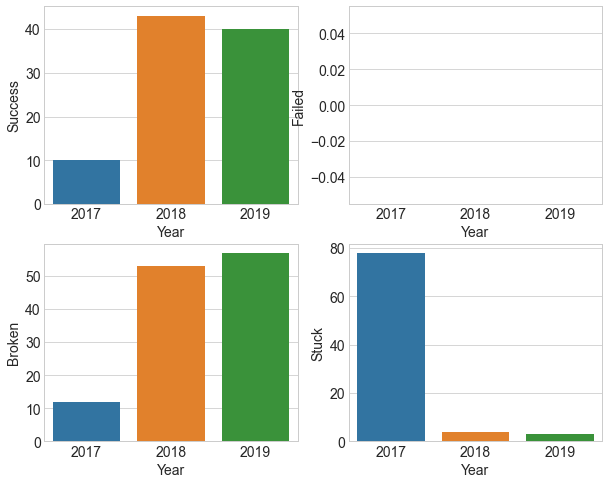

In [32]:
describe_all()